# **TCS Stock Price Analysis and Prediction**

        Date       Open       High        Low      Close  Volume  Dividends  \
0 2002-08-12  28.794172  29.742206  28.794172  29.519140  212976        0.0   
1 2002-08-13  29.556316  30.030333  28.905705  29.119476  153576        0.0   
2 2002-08-14  29.184536  29.184536  26.563503  27.111877  822776        0.0   
3 2002-08-15  27.111877  27.111877  27.111877  27.111877       0        0.0   
4 2002-08-16  26.972458  28.255089  26.582090  27.046812  811856        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4463 non-null   datetime64[ns]
 1   Open          4463 non-null   float64   

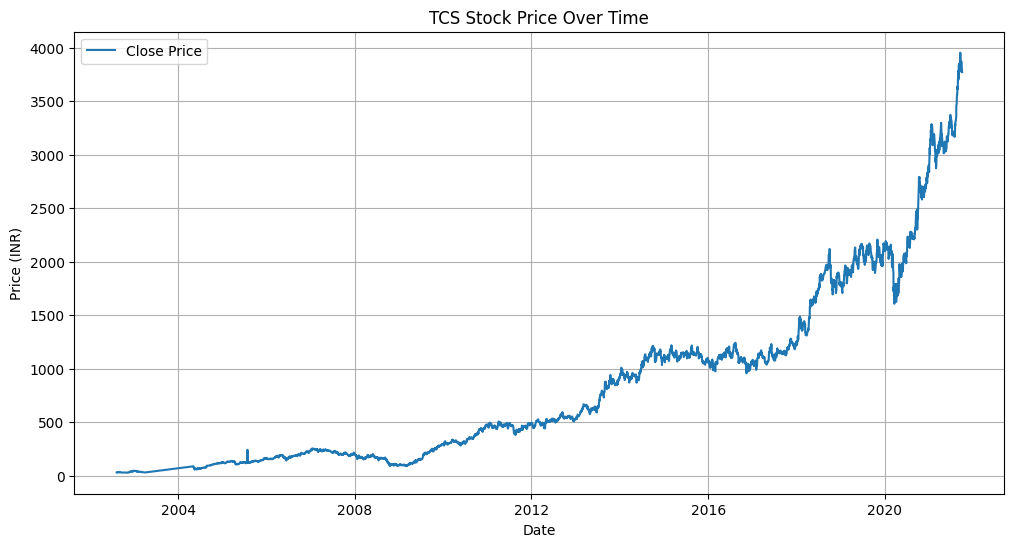

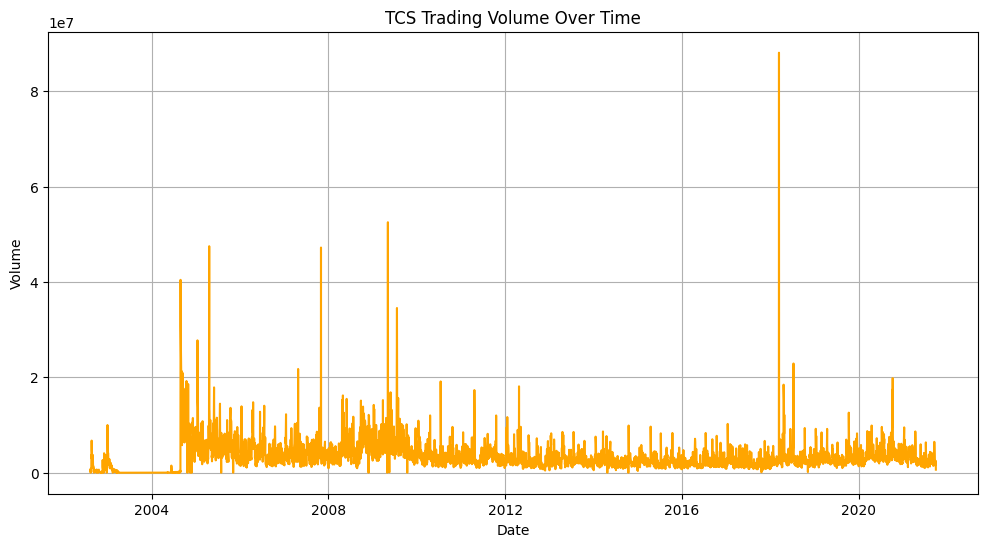

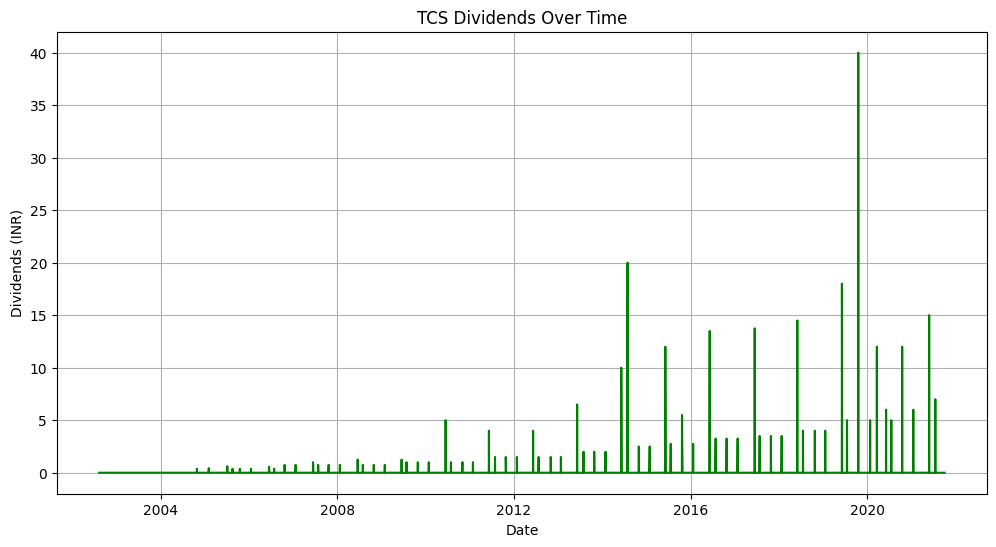

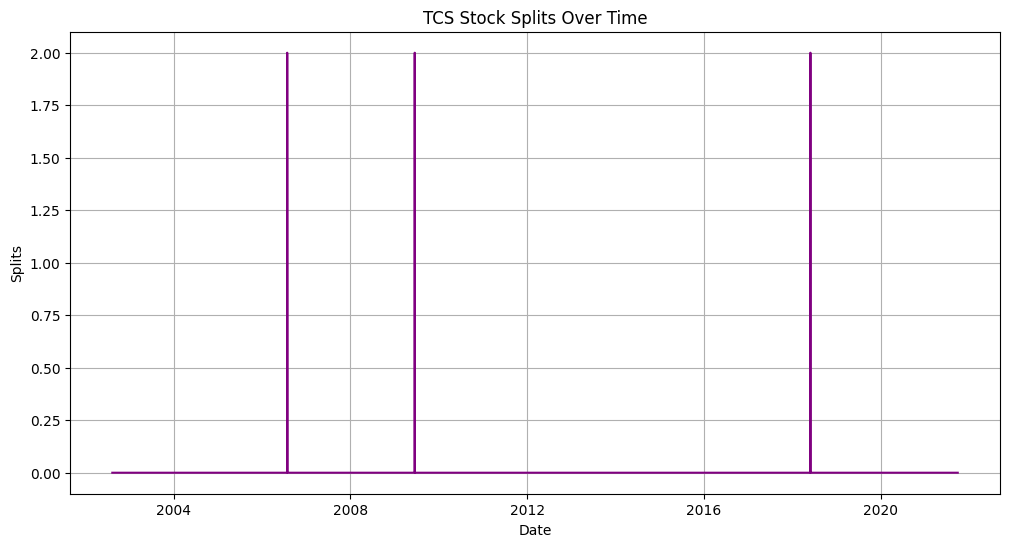

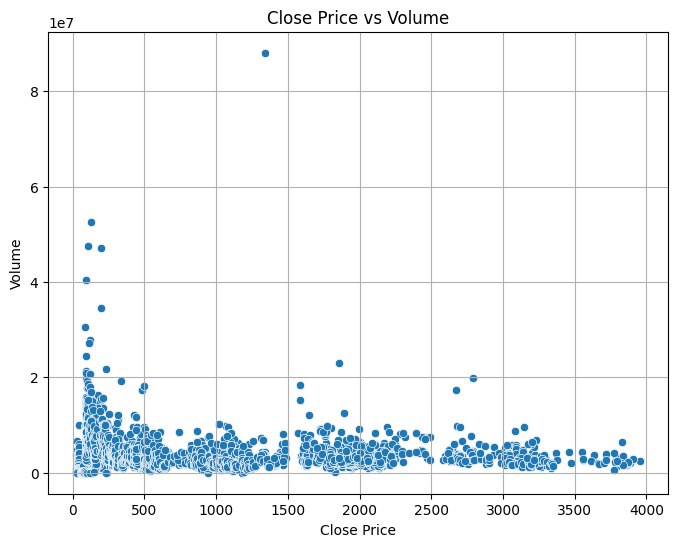

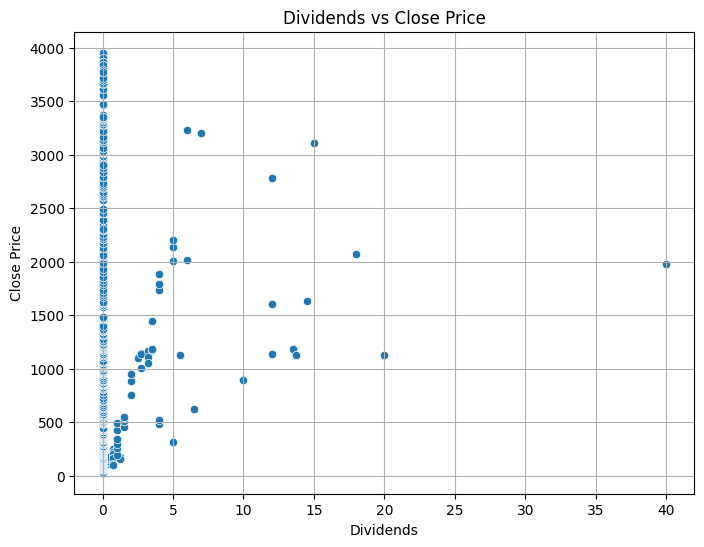

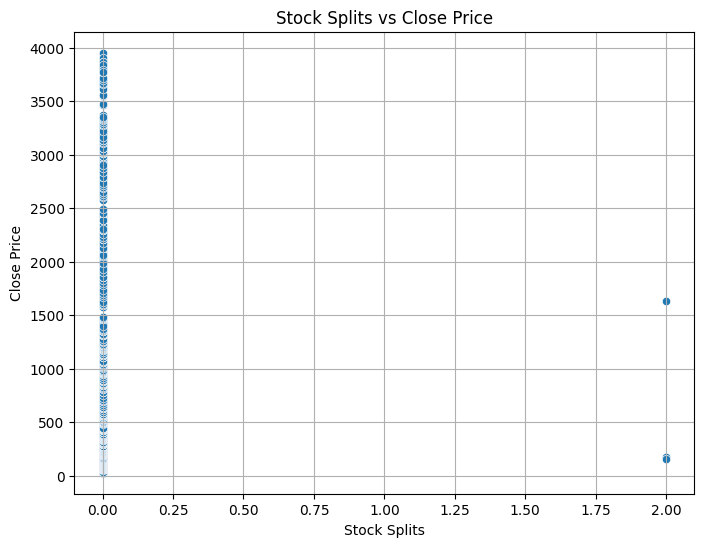

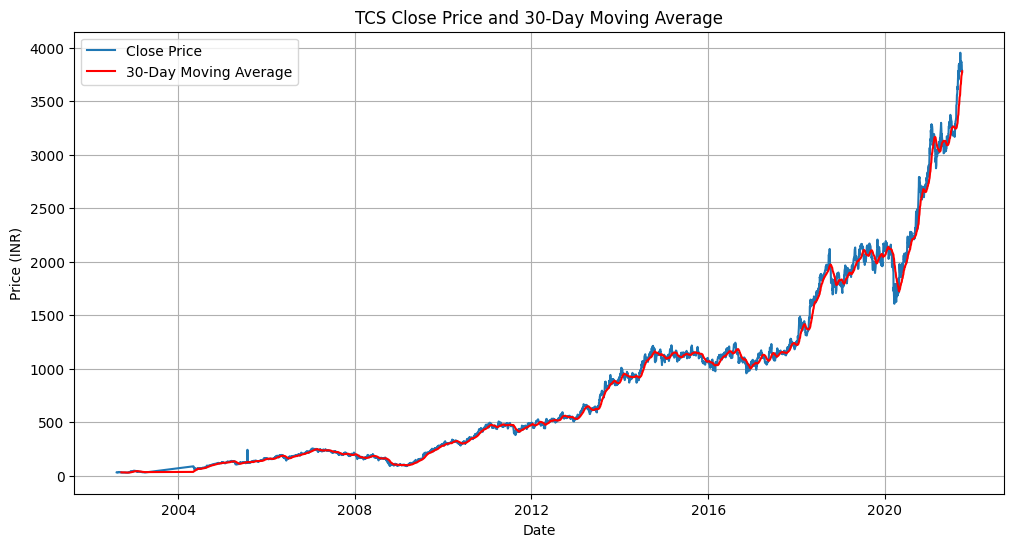

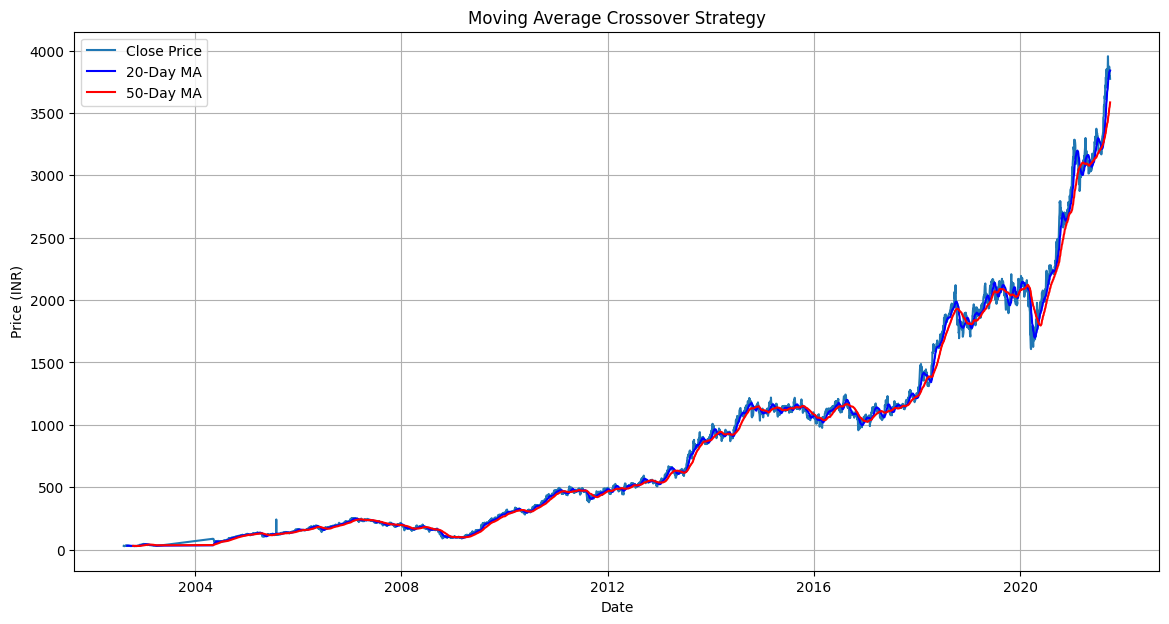

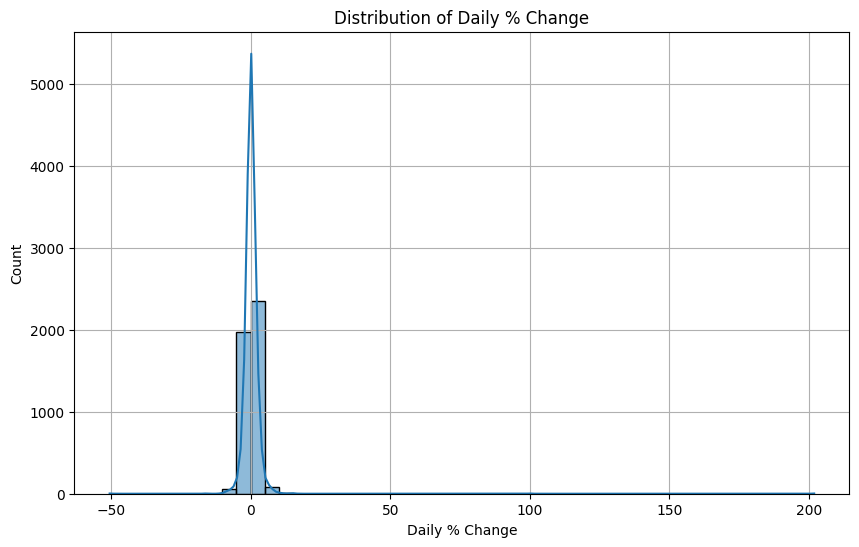

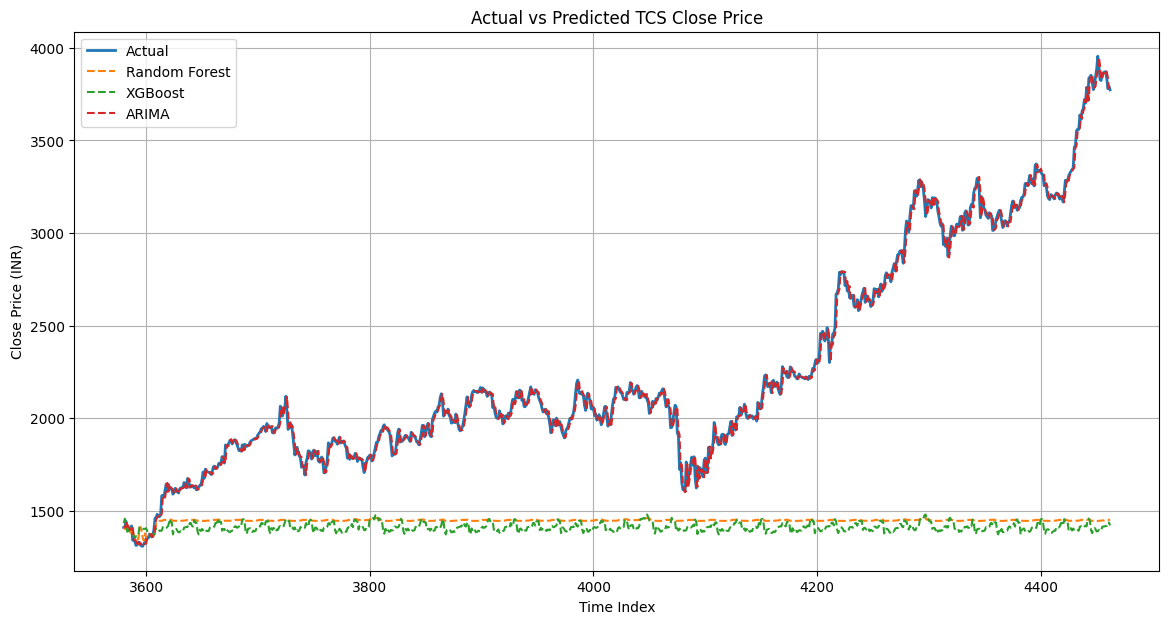

In [ ]:
# Install if needed
# !pip install pandas matplotlib seaborn scikit-learn xgboost statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('/content/TCS_stock_history.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Basic columns assumed: 'Date', 'Close', 'Volume', 'Dividends', 'Stock Splits'
print(df.head())
print(df.columns)
print(df.info())
print(df.describe())

# -----------------------------------
# 1. TCS Stock Price Over Time
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('TCS Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Volume Over Time
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Volume'], color='orange')
plt.title('TCS Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

# 3. Dividends Over Time
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Dividends'], color='green')
plt.title('TCS Dividends Over Time')
plt.xlabel('Date')
plt.ylabel('Dividends (INR)')
plt.grid(True)
plt.show()

# 4. Stock Splits Over Time
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Stock Splits'], color='purple')
plt.title('TCS Stock Splits Over Time')
plt.xlabel('Date')
plt.ylabel('Splits')
plt.grid(True)
plt.show()

# 5. Close Price vs Volume
plt.figure(figsize=(8,6))
sns.scatterplot(x='Close', y='Volume', data=df)
plt.title('Close Price vs Volume')
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

# 6. Dividends vs Close Price
plt.figure(figsize=(8,6))
sns.scatterplot(x='Dividends', y='Close', data=df)
plt.title('Dividends vs Close Price')
plt.xlabel('Dividends')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

# 7. Stock Splits vs Close Price
plt.figure(figsize=(8,6))
sns.scatterplot(x='Stock Splits', y='Close', data=df)
plt.title('Stock Splits vs Close Price')
plt.xlabel('Stock Splits')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

# 8. Close Price and 30-day Moving Average
df['MA30'] = df['Close'].rolling(window=30).mean()

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['MA30'], label='30-Day Moving Average', color='red')
plt.title('TCS Close Price and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

# 9. Moving Average Crossover Strategy (20MA vs 50MA)
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['MA20'], label='20-Day MA', color='blue')
plt.plot(df['Date'], df['MA50'], label='50-Day MA', color='red')
plt.title('Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

# 10. Distribution of Daily Percentage Change
df['Daily Return'] = df['Close'].pct_change() * 100

plt.figure(figsize=(10,6))
sns.histplot(df['Daily Return'].dropna(), bins=50, kde=True)
plt.title('Distribution of Daily % Change')
plt.xlabel('Daily % Change')
plt.grid(True)
plt.show()

# -----------------------------------
# 11. Actual vs Predicted Close Price

# Feature Engineering
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Close_Lag3'] = df['Close'].shift(3)
df.dropna(inplace=True)

X = df[['Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Day', 'Month', 'Year']]
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# XGBoost
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)
xgb_preds = xgbr.predict(X_test)

# ARIMA
ts = df.set_index('Date')['Close']
arima_model = ARIMA(ts, order=(5,1,0))
arima_fit = arima_model.fit()
arima_preds = arima_fit.predict(start=len(ts)-len(y_test), end=len(ts)-1, typ='levels')

# Plot Actual vs Predicted
plt.figure(figsize=(14,7))
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
plt.plot(y_test.index, rf_preds, label='Random Forest', linestyle='dashed')
plt.plot(y_test.index, xgb_preds, label='XGBoost', linestyle='dashed')
plt.plot(y_test.index, arima_preds, label='ARIMA', linestyle='dashed')
plt.title('Actual vs Predicted TCS Close Price')
plt.xlabel('Time Index')
plt.ylabel('Close Price (INR)')
plt.legend()
plt.grid(True)
plt.show()


**No2 Climate Change**

In [ ]:
pip install pandas numpy matplotlib seaborn nltk wordcloud


# CLIMATE CHANGES MODELING

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Before Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           522 non-null    object 
 1   likesCount     522 non-null    int64  
 2   profileName    522 non-null    object 
 3   commentsCount  244 non-null    float64
 4   text           504 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 20.5+ KB
None
                       date  likesCount  \
0  2022-09-07T17:12:32.000Z           2   
1  2022-09-08T14:51:13.000Z           0   
2  2022-09-07T17:19:41.000Z           1   
3  2022-09-08T00:51:30.000Z           4   
4  2022-09-07T19:06:20.000Z          16   

                                         profileName  commentsCount  \
0  4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...            NaN   
1  518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...            NaN   
2  d82e8e24eb633fd625b0aef9b3cb

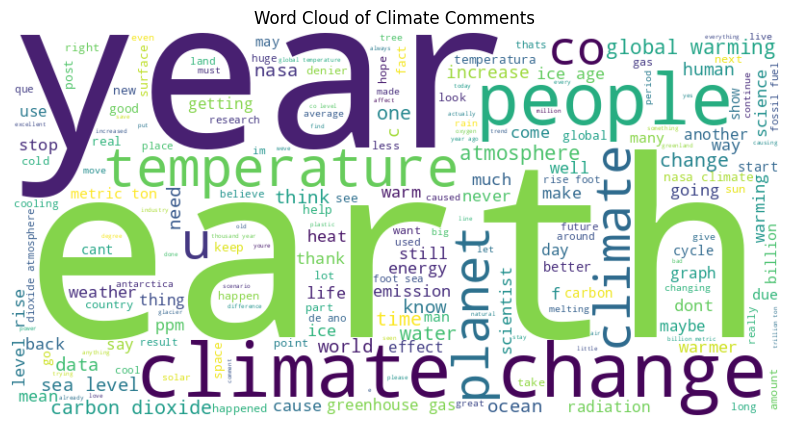

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Download NLTK resources (run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load your dataset
file_path = '/content/climate_nasa.csv'  # <-- update this if needed
df = pd.read_csv(file_path)

# Display basic info
print("Before Cleaning:")
print(df.info())
print(df.head())

# Handle missing values
df['commentsCount'] = df['commentsCount'].fillna(0)
df['likesCount'] = df['likesCount'].fillna(0)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Handle any text-related missing values
df['text'] = df['text'].fillna('')

# Display after cleaning
print("After Cleaning:")
print(df.info())
print(df.head())

# Basic descriptive statistics
print(df.describe())

# -------------------------------------
# TEXT PREPROCESSING FUNCTION
# -------------------------------------

# Initialize stopwords & lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters, numbers, URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords & lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(cleaned_tokens)

# Apply cleaning to text column
df['clean_text'] = df['text'].apply(clean_text)

# Display few cleaned texts
print(df[['text', 'clean_text']].head())

# -------------------------------------
# WORD CLOUD (Visualization)
# -------------------------------------
all_words = ' '.join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Climate Comments')
plt.show()


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


                                                text  \
0  Neat comparison I have not heard it before.\n ...   
1  An excellent way to visualise the invisible! T...   
2  Does the CO2/ghg in the troposphere affect the...   
3  excellent post! I defo feel the difference - o...   
4  Yes, and carbon dioxide does not harm the Eart...   

                                          clean_text  sentiment_score  \
0  neat comparison heard would say co like disco ...           0.7430   
1           excellent way visualise invisible thanks           0.7650   
2  coghg troposphere affect stratosphere warmer t...           0.2960   
3  excellent post defo feel difference one drink ...           0.1027   
4  yes carbon dioxide harm earth like people maki...          -0.3400   

  sentiment_label  
0        Positive  
1        Positive  
2        Positive  
3        Positive  
4        Negative  


<ipython-input-7-2528020787>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=df, palette='viridis')


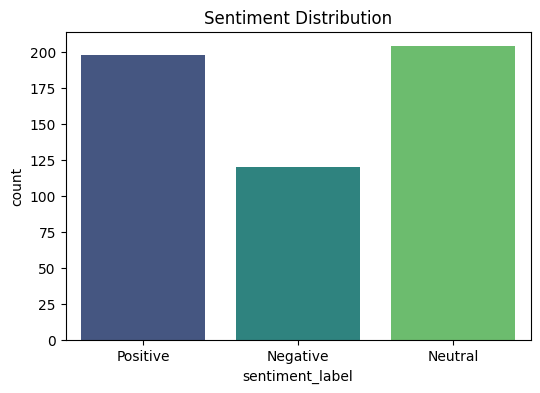

<ipython-input-7-2528020787>:36: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['date'].dt.to_period('M')


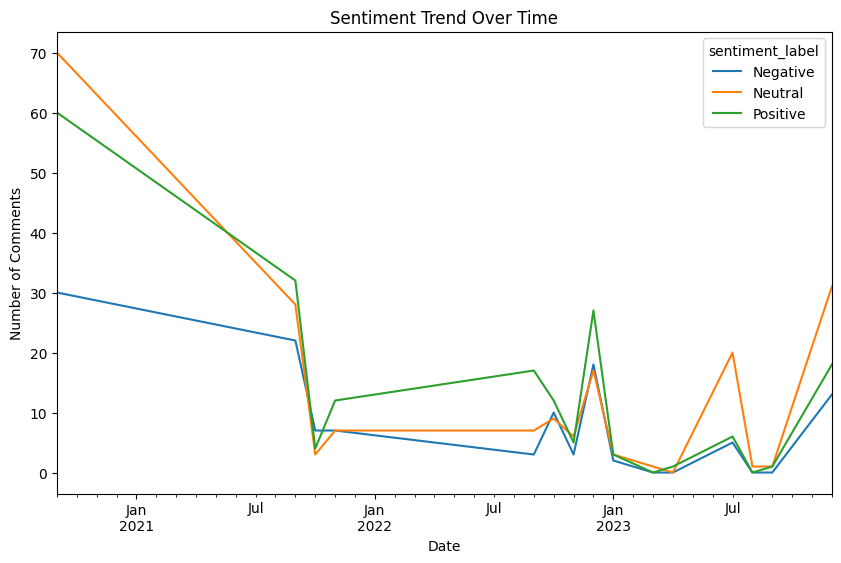

In [ ]:
# Import necessary libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

# Apply sentiment analysis on cleaned text
df['sentiment_score'] = df['clean_text'].apply(get_sentiment)

# Classify into Positive, Neutral, Negative
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_score'].apply(classify_sentiment)

# Show few results
print(df[['text', 'clean_text', 'sentiment_score', 'sentiment_label']].head())

# Sentiment distribution plot
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment_label', data=df, palette='viridis')
plt.title("Sentiment Distribution")
plt.show()

# Sentiment over time
df['year_month'] = df['date'].dt.to_period('M')
sentiment_over_time = df.groupby(['year_month', 'sentiment_label']).size().unstack().fillna(0)

sentiment_over_time.plot(figsize=(10,6))
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.show()


In [ ]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import nltk

# Tokenize cleaned text
df['tokens'] = df['clean_text'].apply(nltk.word_tokenize)

# Build Dictionary
dictionary = corpora.Dictionary(df['tokens'])

# Create Corpus
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# LDA Model Training
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,   # you can change topic number
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Display topics
topics = lda_model.print_topics(num_words=10)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")


Topic 0: 0.016*"earth" + 0.013*"change" + 0.013*"climate" + 0.013*"co" + 0.007*"would" + 0.006*"people" + 0.006*"data" + 0.006*"warming" + 0.006*"atmosphere" + 0.006*"temperature"
Topic 1: 0.008*"year" + 0.007*"climate" + 0.007*"temperature" + 0.007*"earth" + 0.007*"planet" + 0.007*"energy" + 0.006*"people" + 0.006*"one" + 0.006*"know" + 0.005*"change"
Topic 2: 0.015*"climate" + 0.012*"change" + 0.012*"global" + 0.009*"de" + 0.007*"warming" + 0.006*"planet" + 0.006*"ice" + 0.006*"ano" + 0.006*"age" + 0.005*"nasa"
Topic 3: 0.015*"change" + 0.015*"climate" + 0.010*"nasa" + 0.006*"warming" + 0.006*"one" + 0.005*"earth" + 0.005*"say" + 0.004*"think" + 0.004*"u" + 0.004*"year"
Topic 4: 0.020*"year" + 0.013*"carbon" + 0.012*"foot" + 0.011*"water" + 0.011*"sea" + 0.011*"level" + 0.011*"dioxide" + 0.010*"atmosphere" + 0.010*"rise" + 0.009*"ton"


In [ ]:
pip install pyLDAvis


  Using cached numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.9 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
cudf-cu12 25

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare visualization
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Save to HTML file
pyLDAvis.save_html(lda_vis, 'lda_topics.html')

print("Visualization saved successfully as lda_topics.html")


Visualization saved successfully as lda_topics.html


## Life Expectancy Analysis

First 5 rows of dataset:
       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         G

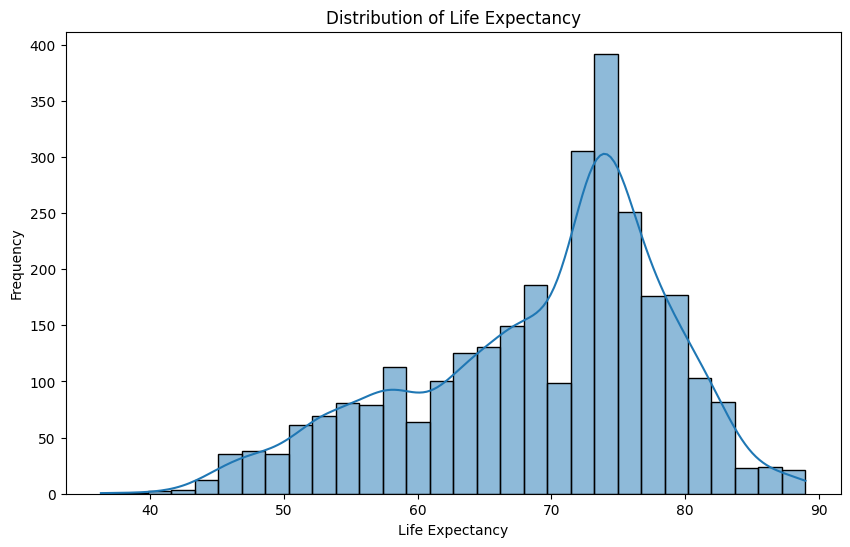

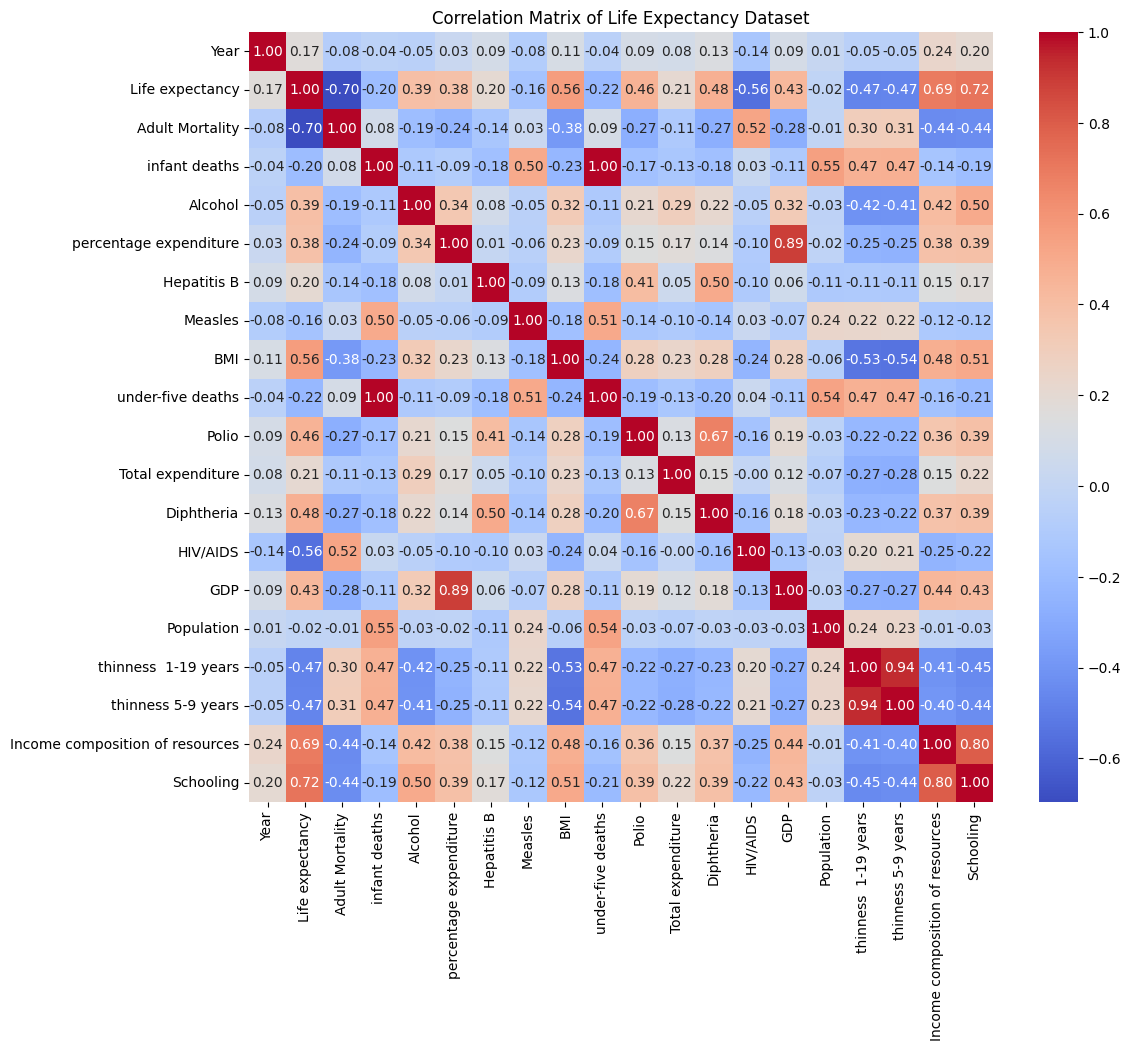

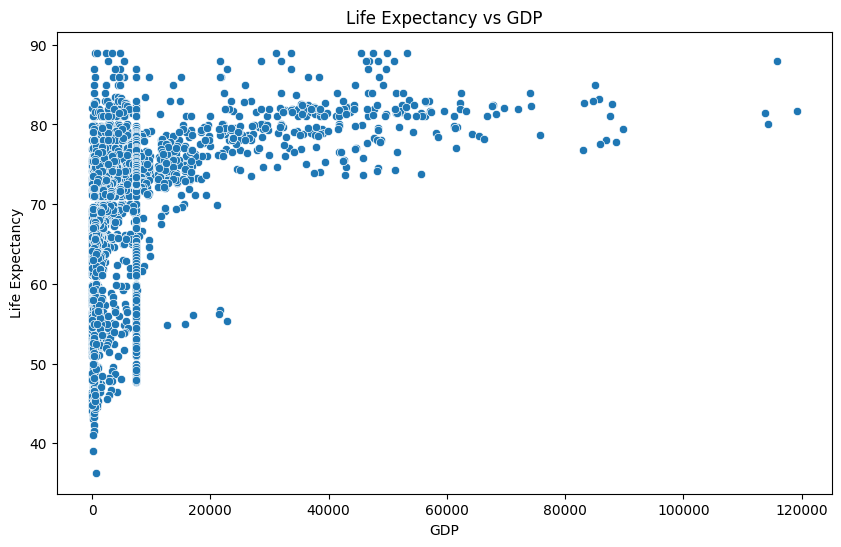


Pearson Correlation between GDP and Life Expectancy: 0.43

T-test Result:
t-statistic = 51.12, p-value = 0.0000
There is a statistically significant difference in life expectancy between high and low income countries.

Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     1113.
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        09:06:38   Log-Likelihood:                -9668.4
No. Observations:                2938   AIC:                         1.934e+04
Df Residuals:                    2934   BIC:                         1.937e+04
Df Model:                           3                                         
Covariance Type:            nonrobust      

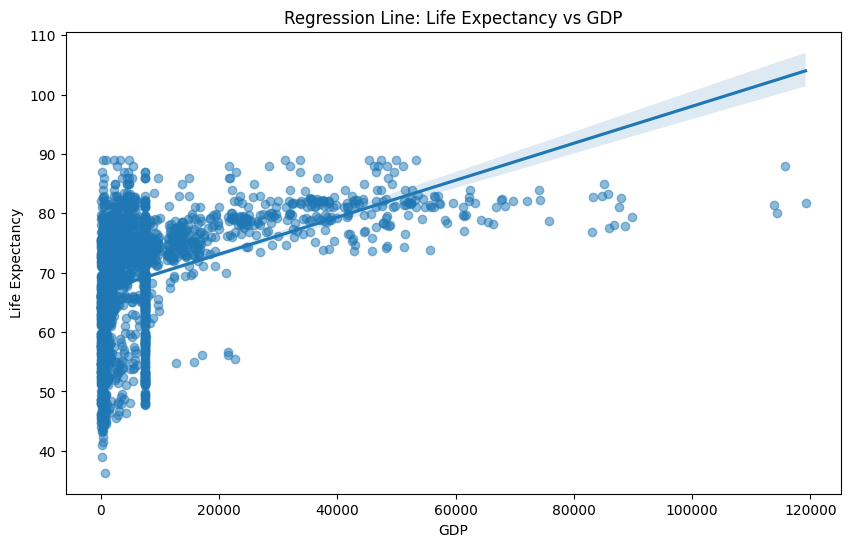

In [ ]:
# ----------------------------------------
# Life Expectancy Analysis Project - Internship
# Full Working Code
# ----------------------------------------

# Import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = "/content/Life Expectancy Data.csv"  # <-- Replace with your correct path if different
df = pd.read_csv(file_path)

# Preview data
print("First 5 rows of dataset:")
print(df.head())

# Check column names (fix if any extra spaces)
df.columns = df.columns.str.strip()

# Quick info
print("\nDataset Information:")
print(df.info())

# Handle missing values (using mean imputation for numeric columns)
# Clean column names

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Handle duplicates
df.drop_duplicates(inplace=True)


# Check for duplicates
df.drop_duplicates(inplace=True)

# ---------------- EDA ----------------

# Distribution of Life Expectancy
plt.figure(figsize=(10, 6))
sns.histplot(df['Life expectancy'], bins=30, kde=True)
plt.title('Distribution of Life Expectancy')
plt.xlabel('Life Expectancy')
plt.ylabel('Frequency')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
# Select numeric columns only for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Life Expectancy Dataset')
plt.show()

# Scatter plot: Life Expectancy vs GDP
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GDP', y='Life expectancy', data=df)
plt.title('Life Expectancy vs GDP')
plt.xlabel('GDP')
plt.ylabel('Life Expectancy')
plt.show()

# ---------------- Statistical Analysis ----------------

# Pearson Correlation between GDP and Life Expectancy
gdp_corr, _ = stats.pearsonr(df['GDP'], df['Life expectancy'])
print(f"\nPearson Correlation between GDP and Life Expectancy: {gdp_corr:.2f}")

# Check income column exists (if not skip T-test)
if 'Income composition of resources' in df.columns:
    # Use this column as proxy for income classification
    median_income = df['Income composition of resources'].median()
    high_income = df[df['Income composition of resources'] >= median_income]['Life expectancy']
    low_income = df[df['Income composition of resources'] < median_income]['Life expectancy']

    t_stat, p_value = stats.ttest_ind(high_income, low_income)

    print(f"\nT-test Result:")
    print(f"t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("There is a statistically significant difference in life expectancy between high and low income countries.")
    else:
        print("No statistically significant difference found between income groups.")
else:
    print("\nIncome classification column not found. Skipping T-test.")

# ---------------- Regression Analysis ----------------

# Select features (modify depending on availability in your data)
features = ['GDP', 'Total expenditure', 'Schooling', 'Adult mortality']
features = [f for f in features if f in df.columns]

X = df[features]
y = df['Life expectancy']

# Handle missing values again for regression safety
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Add constant to regression (intercept)
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

# Print regression summary
print("\nRegression Model Summary:")
print(model.summary())

# Visualize regression for GDP
if 'GDP' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.regplot(x='GDP', y='Life expectancy', data=df, scatter_kws={'alpha':0.5})
    plt.title('Regression Line: Life Expectancy vs GDP')
    plt.xlabel('GDP')
    plt.ylabel('Life Expectancy')
    plt.show()


# Tobacco Use and Mortality, 2004-2015.

In [ ]:
# -------------------------------
# Tobacco Use and Mortality, 2004-2015
# Full Machine Learning Pipeline
# -------------------------------

# 1. Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 2. Load Dataset
df = pd.read_csv('tobacco_mortality_2004_2015.csv')

# 3. Basic Data Exploration
print("Dataset Shape:", df.shape)
print(df.info())
print(df.describe())
print(df.isnull().sum())

# 4. Data Preprocessing

# Handle missing values by filling with mean (for numeric columns only)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Convert categorical columns to numeric (if any)
if 'Status' in df.columns:
    df['Status'] = df['Status'].map({'Developing': 0, 'Developed': 1})

# Drop non-numeric columns if present
if 'Country' in df.columns:
    df.drop(['Country'], axis=1, inplace=True)

# 5. Exploratory Data Analysis (EDA)

# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Histograms
df.hist(bins=30, figsize=(15, 10))
plt.show()

# 6. Feature Selection

# Select features and target
X = df.drop('Life expectancy ', axis=1)   # Note: there may be space after column name
y = df['Life expectancy ']

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 9. Model Training - Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 10. Predictions
y_pred = model.predict(X_test)

# 11. Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# 12. Feature Importance
importances = model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# 13. (Optional) Save Model for Deployment
import joblib
joblib.dump(model, 'tobacco_mortality_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler saved successfully.")


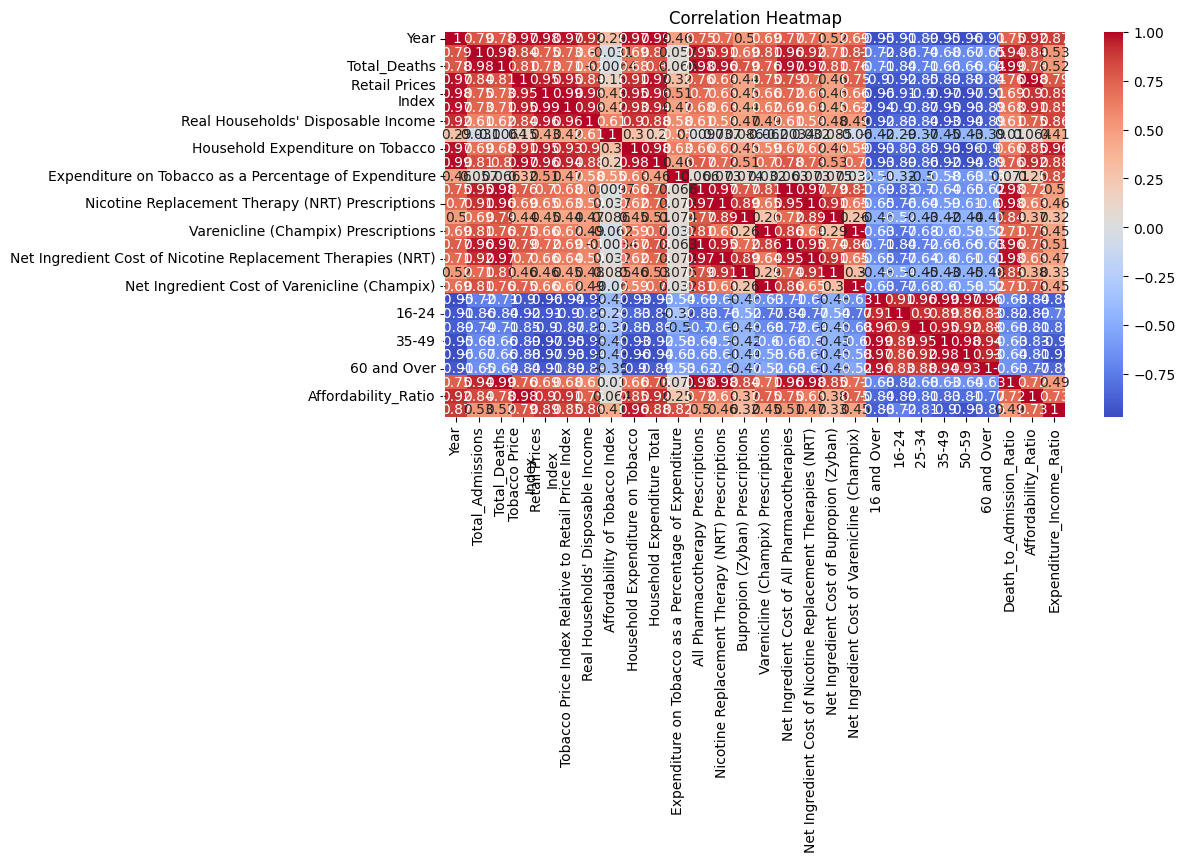

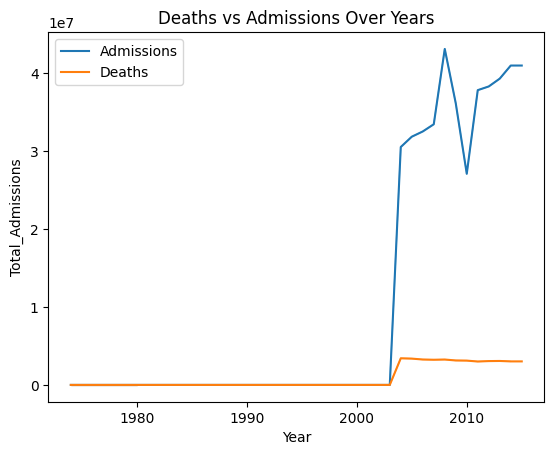

RMSE: 6264.196159527725
R2: 0.9999799714861419


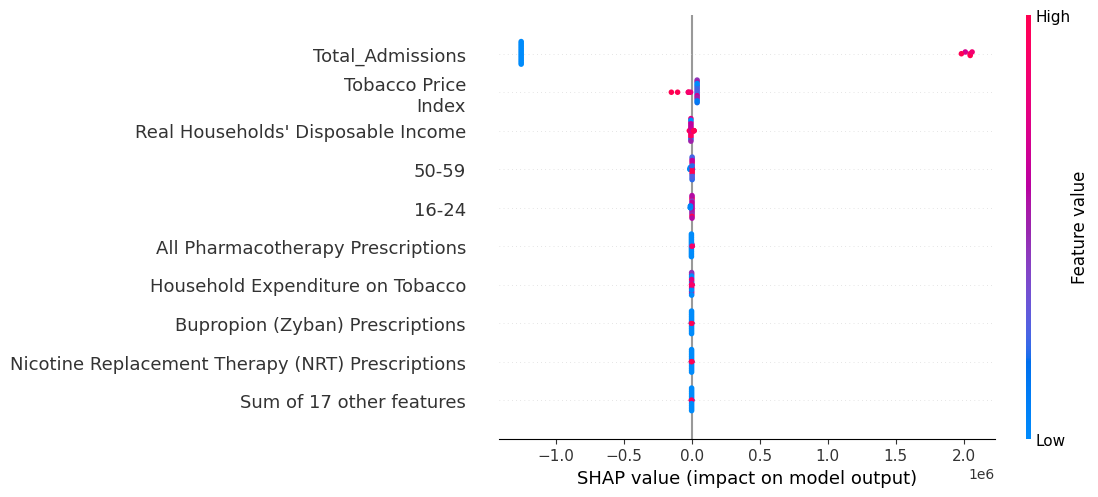

In [ ]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import shap

# 2. Load datasets
df_admissions = pd.read_csv('/content/admissions.csv')
df_deaths = pd.read_csv('/content/fatalities.csv')
df_prices = pd.read_csv('/content/metrics.csv')
df_pharma = pd.read_csv('/content/prescriptions.csv')
df_smoking = pd.read_csv('/content/smokers.csv')

# 3. Clean year columns
df_admissions['Year'] = df_admissions['Year'].str[:4].astype(int)
df_pharma['Year'] = df_pharma['Year'].str[:4].astype(int)
df_deaths['Year'] = df_deaths['Year'].astype(int)
df_prices['Year'] = df_prices['Year'].astype(int)
df_smoking['Year'] = df_smoking['Year'].astype(int)

# Convert Value columns to numeric, coercing errors
df_admissions['Value'] = pd.to_numeric(df_admissions['Value'], errors='coerce')
df_deaths['Value'] = pd.to_numeric(df_deaths['Value'], errors='coerce')
# Check other Value columns if they exist in other dataframes and convert them too
# df_prices['Value'] = pd.to_numeric(df_prices['Value'], errors='coerce') # Assuming metrics has 'Value'
# df_pharma['Value'] = pd.to_numeric(df_pharma['Value'], errors='coerce') # Assuming prescriptions has 'Value'
# df_smoking['Value'] = pd.to_numeric(df_smoking['Value'], errors='coerce') # Assuming smokers has 'Value'


# 4. Aggregate data (sum multiple rows per year)
# Now that 'Value' is numeric, aggregation should work correctly
admissions_sum = df_admissions.groupby('Year')['Value'].sum().reset_index().rename(columns={'Value':'Total_Admissions'})
deaths_sum = df_deaths.groupby('Year')['Value'].sum().reset_index().rename(columns={'Value':'Total_Deaths'})
# Summing other columns in pharma_sum might also need numeric conversion depending on content
pharma_sum = df_pharma.groupby('Year').sum().reset_index()


# 5. Merge datasets
merged_df = admissions_sum.merge(deaths_sum, on='Year', how='outer')\
                          .merge(df_prices, on='Year', how='outer')\
                          .merge(pharma_sum, on='Year', how='outer')\
                          .merge(df_smoking, on='Year', how='outer')

# Ensure the columns used in calculations are numeric after merging and before filling NaNs
for col in ['Total_Deaths', 'Total_Admissions', 'Tobacco Price\nIndex', 'Affordability of Tobacco Index',
            'Household Expenditure on Tobacco', 'Real Households\' Disposable Income']:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')


# 6. Handle missing values
merged_df.fillna(method='ffill', inplace=True)
# After ffill, you might still have NaNs at the beginning of the series
# Fill remaining NaNs if any, e.g., with 0 or mean, depending on context
merged_df.fillna(0, inplace=True) # Or merged_df.fillna(merged_df.mean(), inplace=True)

# 7. Feature Engineering
# Now the columns should be numeric and division should work
merged_df['Death_to_Admission_Ratio'] = merged_df['Total_Deaths'] / merged_df['Total_Admissions']
merged_df['Affordability_Ratio'] = merged_df['Tobacco Price\nIndex'] / merged_df['Affordability of Tobacco Index']
merged_df['Expenditure_Income_Ratio'] = merged_df['Household Expenditure on Tobacco'] / merged_df['Real Households\' Disposable Income']

# Handle potential division by zero after creating ratios
# Replace inf/-inf with NaN, then fill NaNs
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.fillna(0, inplace=True) # Fill ratio NaNs with 0 or another appropriate value

# 8. Visualizations

plt.figure(figsize=(10,5))
sns.heatmap(merged_df.corr(numeric_only=True), annot=True, cmap='coolwarm') # Use numeric_only=True for corr
plt.title("Correlation Heatmap")
plt.show()

sns.lineplot(data=merged_df, x='Year', y='Total_Admissions', label='Admissions')
sns.lineplot(data=merged_df, x='Year', y='Total_Deaths', label='Deaths')
plt.title("Deaths vs Admissions Over Years")
plt.legend()
plt.show()

# 9. Prepare data for ML
# Drop Year again as it's not a feature for the model
X = merged_df.drop(['Year', 'Total_Deaths'], axis=1)
y = merged_df['Total_Deaths']

# Ensure X contains only numeric columns before scaling
X = X.select_dtypes(include=np.number)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 10. XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)

# 11. Evaluation
y_pred = xgb_model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))


X_test_scaled_df = pd.DataFrame(X_test, columns=X.columns)

explainer = shap.Explainer(xgb_model, X_train, feature_names=X.columns.tolist())
shap_values = explainer(X_test_scaled_df) # Pass DataFrame with column names

shap.plots.beeswarm(shap_values)

In [ ]:
import joblib

# Save model
joblib.dump(xgb_model, 'tobacco_deaths_model.pkl')

# Later you can load it:
loaded_model = joblib.load('tobacco_deaths_model.pkl')

# Predict with loaded model
y_pred_loaded = loaded_model.predict(X_test)


In [ ]:
import streamlit as st
import numpy as np
import joblib

# Load model
model = joblib.load("C:\\Users\\sonal\\Downloads\\tobacco_deaths_model.pkl")

st.title("Tobacco Use and Mortality Prediction")
st.write("This app predicts mortality based on tobacco use data.")

# Main user inputs
total_admissions = st.number_input("Total Admissions", min_value=0.0)
tobacco_price_index = st.number_input("Tobacco Price Index", min_value=0.0)
affordability_of_tobacco_index = st.number_input("Affordability of Tobacco Index", min_value=0.0)
household_expenditure_on_tobacco = st.number_input("Household Expenditure on Tobacco", min_value=0.0)
real_household_disposable_income = st.number_input("Real Households' Disposable Income", min_value=0.0)
retail_price_index = st.number_input("Retail Price Index", min_value=0.0)
disposable_income = st.number_input("Disposable Income", min_value=0.0)
num_prescriptions = st.number_input("Number of Prescriptions", min_value=0.0)
total_cost_prescriptions = st.number_input("Total Cost of Prescriptions", min_value=0.0)
num_smokers = st.number_input("Number of Smokers", min_value=0.0)
percent_smokers = st.number_input("Percentage of Smokers", min_value=0.0)

# Age group inputs
age_16_24 = st.number_input("Age group 16-24", min_value=0.0)
age_25_34 = st.number_input("Age group 25-34", min_value=0.0)
age_35_44 = st.number_input("Age group 35-44", min_value=0.0)
age_45_54 = st.number_input("Age group 45-54", min_value=0.0)
age_55_64 = st.number_input("Age group 55-64", min_value=0.0)
age_65_74 = st.number_input("Age group 65-74", min_value=0.0)
age_75_plus = st.number_input("Age group 75+", min_value=0.0)

# Smoking behavior inputs
cigarettes_per_day = st.number_input("Cigarettes per Day", min_value=0.0)
heavy_smokers = st.number_input("Heavy Smokers", min_value=0.0)
avg_cigarettes_per_smoker = st.number_input("Average Cigarettes per Smoker", min_value=0.0)

# Feature Engineering (automated)

# Death_to_Admission_Ratio — We'll assume user doesn't know deaths, so just estimate (optional logic)
death_to_admission_ratio = st.number_input("Death to Admission Ratio (optional)", min_value=0.0)

# Affordability_Ratio
affordability_ratio = 0
if affordability_of_tobacco_index != 0:
    affordability_ratio = tobacco_price_index / affordability_of_tobacco_index

# Expenditure_Income_Ratio
expenditure_income_ratio = 0
if real_household_disposable_income != 0:
    expenditure_income_ratio = household_expenditure_on_tobacco / real_household_disposable_income

# Prepare final input list (26 features)
input_features = [
    total_admissions,
    tobacco_price_index,
    affordability_of_tobacco_index,
    household_expenditure_on_tobacco,
    real_household_disposable_income,
    retail_price_index,
    disposable_income,
    affordability_ratio,
    expenditure_income_ratio,
    death_to_admission_ratio,
    num_prescriptions,
    total_cost_prescriptions,
    num_smokers,
    percent_smokers,
    age_16_24,
    age_25_34,
    age_35_44,
    age_45_54,
    age_55_64,
    age_65_74,
    age_75_plus,
    cigarettes_per_day,
    heavy_smokers,
    avg_cigarettes_per_smoker
]

# Some models expect exact 26 features: we add calculated Death_to_Admission_Ratio twice (for safety, adjust as per your model)
input_data = np.array([input_features + [death_to_admission_ratio]])

if st.button("Predict Mortality"):
    prediction = model.predict(input_data)
    st.success(f"Predicted Mortality: {prediction[0]:.2f}")
